In [1]:
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass

from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras

# Вспомогательные библиотеки
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

TensorFlow 2.x selected.
2.1.0


In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [4]:
# task 3
# Разделите данные на три подвыборки: 
# обучающую (200 тыс. изображений),
# валидационную (10 тыс. изображений)
# и контрольную (тестовую) (19 тыс. изображений);
def split_dataset(dataset):
    learn_dataset = dataset[0:450000]
    print(len(learn_dataset))
    test_dataset = dataset[450001:461955]
    print(len(test_dataset))
    return learn_dataset,test_dataset

def randomize_list(dataset):
    from random import shuffle
    shuffle(dataset)
    return dataset

from tqdm import tqdm
import hashlib
def md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def get_all_files_recursively(path):
    return [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames]

def remove_dublicates(dataset):
    dublicate_remover = dict()
    for file in dataset:
        dublicate_remover[md5(file)] = file
    return list(dublicate_remover.values())

dataset = get_all_files_recursively("notMNIST_large")
# task 4

# Проверьте, что данные из обучающей выборки не пересекаются 
# с данными из валидационной и контрольной выборок. 
# Другими словами, избавьтесь от дубликатов в обучающей выборке.
dataset = remove_dublicates(dataset)
print(len(dataset))
dataset = randomize_list(dataset)
learn_dataset,test_dataset = split_dataset(dataset)

461955
450000
11954


In [5]:
from sklearn.linear_model import LogisticRegression
# from tqdm.notebook import tqdm
import numpy as np
from PIL import Image

alphabet = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9}
class_names = "ABCDEFGHIJ"
# def Learn(X_train, y_train, X_test, y_test):
#     clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#     predicted = clf.predict(X_test)
#     score = clf.score(X_test, y_test) 
#     print(score)
#     return score

def GetClassData(path):
    return alphabet[path.split("/")[1]]


def GetLearnData(learn_dataset, test_dataset, train_len=len(learn_dataset)):
    X_train, y_train, X_test, y_test = [],[],[],[] 
    for index in tqdm(range(train_len)):
        path = learn_dataset[index]
        try:
            img = Image.open(path)
        except:
            continue
        arr = np.array(img)
        X_train.append(arr)
        y_train.append(GetClassData(path))
    for path in tqdm(test_dataset):
        try:
            img = Image.open(path)
        except:
            continue
        arr = np.array(img)
        X_test.append(arr)
        y_test.append(GetClassData(path))
    return (X_train, y_train), (X_test, y_test)


(train_images, train_labels), (test_images, test_labels)  = GetLearnData(learn_dataset, test_dataset)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

100%|██████████| 11954/11954 [00:01<00:00, 8945.71it/s]


In [0]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [0]:
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

Задание 1.
Реализуйте нейронную сеть с двумя сверточными слоями, и одним полносвязным с нейронами с кусочно-линейной функцией активации. Какова точность построенное модели?


In [0]:
model = models.Sequential()
model.add(layers.Conv2D(28, (1, 1), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(56, (1, 1), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(56, activation='relu'))
model.add(layers.Dense(10))

Train on 449998 samples, validate on 11954 samples
Epoch 1/10
449998/449998 [==============================] - 529s 1ms/sample - loss: 0.5125 - accuracy: 0.8463 - val_loss: 0.4456 - val_accuracy: 0.8673
Epoch 2/10
449998/449998 [==============================] - 501s 1ms/sample - loss: 0.4272 - accuracy: 0.8711 - val_loss: 0.4216 - val_accuracy: 0.8739
Epoch 3/10
449998/449998 [==============================] - 537s 1ms/sample - loss: 0.3985 - accuracy: 0.8790 - val_loss: 0.4099 - val_accuracy: 0.8779
Epoch 4/10
449998/449998 [==============================] - 536s 1ms/sample - loss: 0.3786 - accuracy: 0.8847 - val_loss: 0.4020 - val_accuracy: 0.8804
Epoch 5/10
449998/449998 [==============================] - 501s 1ms/sample - loss: 0.3619 - accuracy: 0.8889 - val_loss: 0.4062 - val_accuracy: 0.8815
Epoch 6/10
449998/449998 [==============================] - 500s 1ms/sample - loss: 0.3474 - accuracy: 0.8931 - val_loss: 0.4096 - val_accuracy: 0.8764
Epoch 7/10
449998/449998 [===========

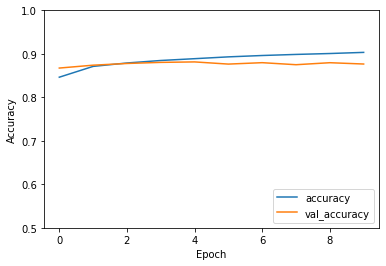

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print("Точность модели:",test_acc)

Задание 2.
Замените один из сверточных слоев на слой, реализующий операцию пулинга (Pooling) с функцией максимума или среднего. Как это повлияло на точность классификатора?


449998/449998 [==============================] - 134s 298us/sample - loss: 0.5463 - accuracy: 0.8384 - val_loss: 0.4743 - val_accuracy: 0.8565
Epoch 2/10
449998/449998 [==============================] - 133s 295us/sample - loss: 0.4718 - accuracy: 0.8601 - val_loss: 0.4510 - val_accuracy: 0.8663
Epoch 3/10
449998/449998 [==============================] - 134s 298us/sample - loss: 0.4514 - accuracy: 0.8659 - val_loss: 0.4358 - val_accuracy: 0.8695
Epoch 4/10
449998/449998 [==============================] - 133s 296us/sample - loss: 0.4395 - accuracy: 0.8690 - val_loss: 0.4341 - val_accuracy: 0.8708
Epoch 5/10
449998/449998 [==============================] - 132s 293us/sample - loss: 0.4310 - accuracy: 0.8717 - val_loss: 0.4308 - val_accuracy: 0.8718
Epoch 6/10
449998/449998 [==============================] - 128s 285us/sample - loss: 0.4252 - accuracy: 0.8731 - val_loss: 0.4242 - val_accuracy: 0.8743
Epoch 7/10
449998/449998 [==============================] - 128s 283us/sample - loss: 0

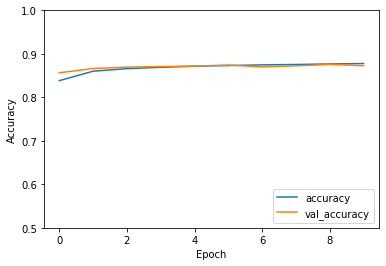

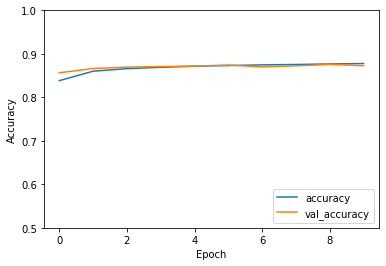

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(28, (1, 1), activation='relu', input_shape=(28, 28, 1)))
# слой, реализующий операцию пулинга
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(56, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print("Точность модели:",test_acc)

Задание 3.
Реализуйте классическую архитектуру сверточных сетей LeNet-5 (http://yann.lecun.com/exdb/lenet/).


449998/449998 [==============================] - 169s 375us/sample - loss: 1.5929 - accuracy: 0.8678 - val_loss: 1.5848 - val_accuracy: 0.8758
Epoch 3/10
449998/449998 [==============================] - 161s 359us/sample - loss: 1.5845 - accuracy: 0.8761 - val_loss: 1.5890 - val_accuracy: 0.8718
Epoch 4/10
449998/449998 [==============================] - 161s 358us/sample - loss: 1.5818 - accuracy: 0.8787 - val_loss: 1.5786 - val_accuracy: 0.8822
Epoch 5/10
449998/449998 [==============================] - 158s 351us/sample - loss: 1.5781 - accuracy: 0.8826 - val_loss: 1.5824 - val_accuracy: 0.8782
Epoch 6/10
449998/449998 [==============================] - 175s 389us/sample - loss: 1.5767 - accuracy: 0.8841 - val_loss: 1.5810 - val_accuracy: 0.8799
Epoch 7/10
449998/449998 [==============================] - 168s 373us/sample - loss: 1.5759 - accuracy: 0.8849 - val_loss: 1.5811 - val_accuracy: 0.8798
Epoch 8/10
449998/449998 [==============================] - 170s 378us/sample - loss: 1

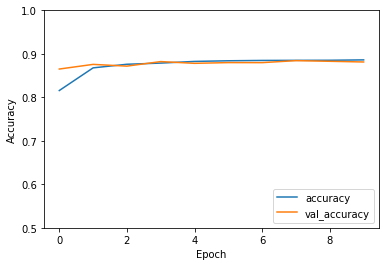

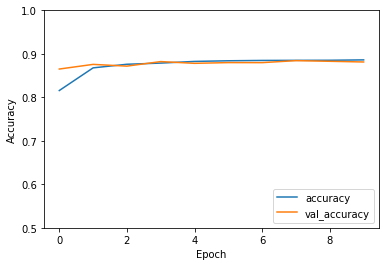

In [24]:
model = keras.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(layers.AveragePooling2D())
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=10, activation = 'softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print("Точность модели:",test_acc)

Задание 4.
Сравните максимальные точности моделей, построенных в лабораторных работах 1-3. Как можно объяснить полученные различия?


| Номер лабораторной работы  | Максимальная точность  |
|---|---|
|  1 |0.8068   |
|   2|**0.8889**   |
|   3| 0.8812   |


Объяснение: в лабораторных работах исопльховались различные методы классификации изображений. Наиболее точным методом оказалось использование метода из второй лабораторной работы т.к метод использует стохастический градиент для более точной классификациии.